In [ ]:
!pip install featuretools

In [ ]:
from google.colab import auth
auth.authenticate_user()

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
data_drop = drive.CreateFile({'id':'1OtzpLNq_s8UtWQgPXJEQX6ejJ92lEwkH'})
data_drop.GetContentFile('dropoff_neighborhoods.csv')
data_pick = drive.CreateFile({'id':'1CE8P9xjJYirrE3sN3xPp-Cc9wKYoNGxU'})
data_pick.GetContentFile('pickup_neighborhoods.csv')
data_trips = drive.CreateFile({'id':'19kUSme4S1hfcUJn3JovQd_mvw54il1QI'})
data_trips.GetContentFile('trips.pkl')

In [ ]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday)
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

print('Import successful!')

Import successful!


In [ ]:
def load_nyc_taxi_data():
    trips = pd.read_pickle('trips.pkl')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv(
        "pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv(
        "dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

In [ ]:
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values(kind='mergesort').head(n).index
    return df.loc[order]

#Data

Here we should load the data by calling the load_nyc_taxi_data() method.

This method returns the following entities: trips, pickup_neighborhoods, dropoff_neighborhoods.

In [ ]:
##Call load_nyc_taxi_data() method here...and return trips, pickup_neighborhoods, dropoff_neighborhoods
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)
print('Data load successful!')

Data load successful!


We can also plot some aspects of the data to get a better sense of its distributions. For instance, here is the `trip_duration` variable we are going to try to predict.

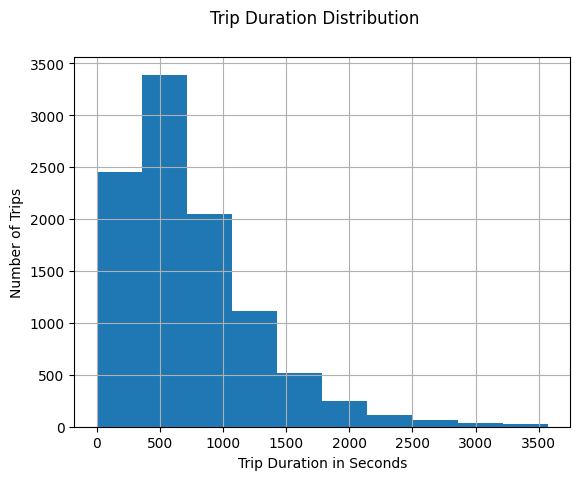

Histogram generation successful!


In [ ]:
#Write code to plot trip durations by number of trips
trips.trip_duration.hist()
plt.xlabel('Trip Duration in Seconds')
plt.ylabel('Number of Trips')
plt.suptitle('Trip Duration Distribution')
plt.show()
print('Histogram generation successful!')

In [ ]:
#Get the count of trips in our trips dataset.
print(trips.count())
#You can also use .describe() which is a dataframe pandas method
print(trips.describe())


id                      10000
vendor_id               10000
pickup_datetime         10000
dropoff_datetime        10000
passenger_count         10000
trip_distance           10000
pickup_longitude        10000
pickup_latitude         10000
dropoff_longitude       10000
dropoff_latitude        10000
payment_type            10000
trip_duration           10000
pickup_neighborhood      9816
dropoff_neighborhood     9835
dtype: int64
                 id     vendor_id  passenger_count  trip_distance  \
count   10000.00000  10000.000000     10000.000000   10000.000000   
mean   519029.50000      1.527400         1.698100       2.743312   
std      2886.89568      0.499274         1.303045       3.134647   
min    514030.00000      1.000000         1.000000       0.000000   
25%    516529.75000      1.000000         1.000000       1.000000   
50%    519029.50000      2.000000         1.000000       1.700000   
75%    521529.25000      2.000000         2.000000       3.200000   
max    524029.0

Question 1: Data Analysis

Describe the dataset. How many trips are in the dataset? How would you describe the distribution of the trip durations? What other things can you observe?

**ANSWER 1:**

*The dataset is a timeseries dataset that contains data related to 10,000 trips in total.*

*The average trip duration is of approx. 746 seconds (or 12mins 26secs) with a standard deviation of 525 and a median (50th percentile) of 616.*

 *The distribution of the trip durations is positively-skewed (right-skewed) since the mode is greater than the median and the median is greater than the mean value.*


---



Ensure that you remove the records with null reference ids "neighborhood_id". Null references keys can cause errors in the DFS algorithm below

In [ ]:
print(pickup_neighborhoods.count())

pickup_neighborhoods = pickup_neighborhoods[pickup_neighborhoods['neighborhood_id'].notna()]
print(pickup_neighborhoods.count())

dropoff_neighborhoods = dropoff_neighborhoods[dropoff_neighborhoods['neighborhood_id'].notna()]
print(dropoff_neighborhoods.count())


neighborhood_id    49
latitude           50
longitude          50
dtype: int64
neighborhood_id    49
latitude           49
longitude          49
dtype: int64
neighborhood_id    49
latitude           49
longitude          49
dtype: int64


#Create Transform Primitives by using DFS

In [ ]:
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

print('Entities and relationships successful!')

Entities and relationships successful!


In [ ]:
trans_primitives = [Month]

# https://featuretools.alteryx.com/en/stable/generated/featuretools.dfs.html
feature_matrix, feature_names = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name ="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns ={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=False,
                  )


print('Transform primitives successful!')

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:414: UserWarning: Logical type Categorical for child column pickup_neighborhood does not match parent column neighborhood_id logical type Unknown. Changing child logical type to match parent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:414: UserWarning: Logical type Categorical for child column dropoff_neighborhood does not match parent column neighborhood_id logical type Unknown. Changing child logical type to match parent.
  warnings.warn(


Transform primitives successful!


Below are the features that we just created

In [ ]:
#Write code to show the number of features, as well as all the feature names as a list
n_features = feature_names.count(feature_names)
print("Number of features: ",n_features)
print(feature_names)

Number of features:  10
[<Feature: vendor_id>, <Feature: passenger_count>, <Feature: trip_distance>, <Feature: payment_type>, <Feature: MONTH(dropoff_datetime)>, <Feature: MONTH(pickup_datetime)>, <Feature: pickup_neighborhoods.latitude>, <Feature: pickup_neighborhoods.longitude>, <Feature: dropoff_neighborhoods.latitude>, <Feature: dropoff_neighborhoods.longitude>]


Lets review the features_matrix by calling the preview(feature_matrix, n_features) function

In [ ]:
#Call the preview function and show 5 records
preview(feature_matrix, 5)

,vendor_id,passenger_count,trip_distance,payment_type,MONTH(dropoff_datetime),MONTH(pickup_datetime),pickup_neighborhoods.latitude,pickup_neighborhoods.longitude,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude
id,,,,,,,,,,
514030,2,1,2.46,1,4,4,40.757707,-73.986446,40.766809,-73.956886
514031,1,2,7.90,1,4,4,40.744928,-73.919159,40.793597,-73.969822
514032,1,1,1.00,1,4,4,40.729652,-73.991595,40.740333,-74.005107
514033,2,1,0.02,2,4,4,40.720245,-73.987205,40.720245,-73.987205
514034,1,2,19.00,1,4,4,40.646194,-73.785073,40.785005,-73.976050


#Building our Basic Model

In [ ]:
from sklearn.impute import SimpleImputer #replaces missing values with means

def get_train_test_fm(feature_matrix, original_data, percentage):
    imp = SimpleImputer()

    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows - head

    X_train = feature_matrix.head(head)
    y_train = original_data.head(head).trip_duration

    X_train = imp.fit_transform(X_train)

    X_test = feature_matrix.tail(tail)
    y_test = original_data.tail(tail).trip_duration
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test, y_test)


In [ ]:
# Re-split data
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix,trips, .75) #pass (feature matrix, trips dataset, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

Data split successful!


In [ ]:
# Create a model using the GradientBoostingRegressor()
model = GradientBoostingRegressor(verbose=True)
# fit the model by calling the model.fit() by passing the X_train and y_train as parameters
model.fit(X_train, y_train)
# Get the model scores by calling the model.score() function and pass the X_test and y_test as parameters
model.score(X_test, y_test)
print(model.score(X_test, y_test)) # Print the scores by calling the scores method in the print function. This is the R^2 value of the prediction

print('Training successful!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.06s
         2           0.4148            1.40s
         3           0.3661            1.16s
         4           0.3266            1.04s
         5           0.2934            0.98s
         6           0.2665            0.92s
         7           0.2441            0.90s
         8           0.2257            0.87s
         9           0.2103            0.85s
        10           0.1973            0.82s
        20           0.1435            0.67s
        30           0.1315            0.57s
        40           0.1262            0.48s
        50           0.1231            0.39s
        60           0.1209            0.31s
        70           0.1188            0.23s
        80           0.1167            0.16s
        90           0.1154            0.08s
       100           0.1139            0.00s
0.7563732112218262
Training successful!


Question 2: First Model Features

Describe the first automated features that we created for the model.

**ANSWER 2:**

*The automated features created are adding an entry for the corresponding `MONTH`, `WEEK`, `WEEKDAY`, `DAY`, `HOUR` and `MINUTE` value for `pickup_datetime` and `dropoff_datetime`*

*After training with the* ***GradientBoostingRegressor*** *we can observe that the training loss improved with each iteration indicating that the model was improving*

*The GradientBoostingRegressor gives us a R^2 evaluation metric of approx. `75.6%` - the higher the value of this metric, the better the fit of the model to the training dataset.*


---



#Adding Further Transform Primitives to our Model

In [ ]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday]

feature_matrix, feature_names = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=False) #This returns the feature_matrix as well as feature_names. If set to true only feature_names are returned

print('Aggregation primitives successful!')

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(


Aggregation primitives successful!


In [ ]:
#Write code to show the number of features, as well as all the feature names as a list
n_features = feature_names.count(feature_names)
print ("Number of features = ", n_features)
print(feature_names)

Number of features =  20
[<Feature: vendor_id>, <Feature: passenger_count>, <Feature: trip_distance>, <Feature: payment_type>, <Feature: DAY(dropoff_datetime)>, <Feature: DAY(pickup_datetime)>, <Feature: HOUR(dropoff_datetime)>, <Feature: HOUR(pickup_datetime)>, <Feature: MINUTE(dropoff_datetime)>, <Feature: MINUTE(pickup_datetime)>, <Feature: MONTH(dropoff_datetime)>, <Feature: MONTH(pickup_datetime)>, <Feature: WEEK(dropoff_datetime)>, <Feature: WEEK(pickup_datetime)>, <Feature: WEEKDAY(dropoff_datetime)>, <Feature: WEEKDAY(pickup_datetime)>, <Feature: pickup_neighborhoods.latitude>, <Feature: pickup_neighborhoods.longitude>, <Feature: dropoff_neighborhoods.latitude>, <Feature: dropoff_neighborhoods.longitude>]


In [ ]:
# Re-split data
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix, trips, .75) #pass (feature matrix, trips dataset, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

Data split successful!


In [ ]:
# Create a model using the GradientBoostingRegressor()
model = GradientBoostingRegressor(verbose=True)
# fit the model by calling the model.fit() by passing the X_train and y_train as parameters
model.fit(X_train, y_train)
# Get the model scores by calling the model.score() function and pass the X_test and y_test as parameters
model.score(X_test, y_test)
print("R^2 Value: ",model.score(X_test, y_test)) # Print the scores by calling the scores method in the print function. This is the R^2 value of the prediction

print('Training successful!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.26s
         2           0.4148            1.57s
         3           0.3661            1.44s
         4           0.3264            1.35s
         5           0.2930            1.29s
         6           0.2660            1.25s
         7           0.2432            1.22s
         8           0.2245            1.19s
         9           0.2090            1.17s
        10           0.1960            1.14s
        20           0.1362            0.98s
        30           0.1202            0.86s
        40           0.1128            0.74s
        50           0.1082            0.60s
        60           0.1049            0.48s
        70           0.1027            0.36s
        80           0.1006            0.24s
        90           0.0962            0.12s
       100           0.0913            0.00s
R^2 Value:  0.8080197351946704
Training successful!


Question 3: Second Model

Describe the rest of new features we added to the model. How did this affect the performance of our model? How did this affect our training time?


**ANSWER 3:**

*The newly generated features extract more complex information from the `pickup_neighborhoods` and `dropoff_neighborhoos` fields, such as the `COUNT` of the trips at that neighbourhood, the maximum number of passengers per trip, the maximum and minimum trip distances, the total sum of the trip distance, etc..  In total there are another 50 new featurs added to the model.

*As can be expected adding more features to the model makes it take significantly longer to train (approx 2s vs 0.8s). The training loss in each iteration is also significantly decreased.*

*The R^2 value has also increased to approx `80.8%` which indicates that this model is approximately 5% better at predicting our dataset than the previous one and that therefore at least some of the additional  features generated are useful to the model.*


---



#Aggregation Primitives

In [ ]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

feature_matrix, feature_names = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=False)

print('Aggregation primitives successful!')

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(


Aggregation primitives successful!


In [ ]:
#Show feature count and all the features that we now have
n_features = feature_names.count(feature_names)
print ("Number of features = ", n_features)
print(feature_names)

Number of features =  70
[<Feature: vendor_id>, <Feature: passenger_count>, <Feature: trip_distance>, <Feature: payment_type>, <Feature: DAY(dropoff_datetime)>, <Feature: DAY(pickup_datetime)>, <Feature: HOUR(dropoff_datetime)>, <Feature: HOUR(pickup_datetime)>, <Feature: MINUTE(dropoff_datetime)>, <Feature: MINUTE(pickup_datetime)>, <Feature: MONTH(dropoff_datetime)>, <Feature: MONTH(pickup_datetime)>, <Feature: WEEK(dropoff_datetime)>, <Feature: WEEK(pickup_datetime)>, <Feature: WEEKDAY(dropoff_datetime)>, <Feature: WEEKDAY(pickup_datetime)>, <Feature: pickup_neighborhoods.latitude>, <Feature: pickup_neighborhoods.longitude>, <Feature: dropoff_neighborhoods.latitude>, <Feature: dropoff_neighborhoods.longitude>, <Feature: pickup_neighborhoods.COUNT(trips)>, <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>, <Feature: pickup_neighborhoods.MAX(trips.payment_type)>, <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>, <Feature: pickup_neighborhoods.MAX(trips.vendor_id)>, <F

In [ ]:
#preview 5 records in our feature matrix by calling the preview function
preview(feature_matrix,5)

,vendor_id,passenger_count,trip_distance,payment_type,DAY(dropoff_datetime),DAY(pickup_datetime),HOUR(dropoff_datetime),HOUR(pickup_datetime),MINUTE(dropoff_datetime),MINUTE(pickup_datetime),...,dropoff_neighborhoods.MIN(trips.trip_distance),dropoff_neighborhoods.MIN(trips.vendor_id),dropoff_neighborhoods.STD(trips.passenger_count),dropoff_neighborhoods.STD(trips.payment_type),dropoff_neighborhoods.STD(trips.trip_distance),dropoff_neighborhoods.STD(trips.vendor_id),dropoff_neighborhoods.SUM(trips.passenger_count),dropoff_neighborhoods.SUM(trips.payment_type),dropoff_neighborhoods.SUM(trips.trip_distance),dropoff_neighborhoods.SUM(trips.vendor_id)
id,,,,,,,,,,,,,,,,,,,,,
514030,2,1,2.46,1,2,2,0,0,17,0,...,0.00,1.0,1.313686,0.470580,2.086730,0.495500,512.0,392.0,603.25,464.0
514031,1,2,7.90,1,2,2,0,0,24,0,...,0.30,1.0,1.266439,0.467941,2.742837,0.495777,293.0,239.0,443.74,285.0
514032,1,1,1.00,1,2,2,0,0,19,0,...,0.00,1.0,1.311967,0.486889,1.706576,0.500502,505.0,391.0,556.44,445.0
514033,2,1,0.02,2,2,2,0,0,1,0,...,0.00,1.0,1.307116,0.467893,2.745361,0.500776,491.0,358.0,714.12,426.0
514034,1,2,19.00,1,2,2,0,0,58,1,...,0.17,1.0,1.248404,0.474956,2.664571,0.500012,482.0,393.0,661.57,448.0


In [ ]:
# Re-split data
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix,trips, .75) #pass (feature matrix, trips dataset, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

Data split successful!


In [ ]:
# Create a model using the GradientBoostingRegressor()
model = GradientBoostingRegressor(verbose=True)
# fit the model by calling the model.fit() by passing the X_train and y_train as parameters
model.fit(X_train, y_train)
# Get the model scores by calling the model.score() function and pass the X_test and y_test as parameters
model.score(X_test, y_test)
print(model.score(X_test, y_test)) # Print the scores by calling the scores method in the print function. This is the R^2 value of the prediction


print('Training successful!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            5.13s
         2           0.4148            5.46s
         3           0.3661            6.00s
         4           0.3264            5.99s
         5           0.2930            5.92s
         6           0.2660            5.85s
         7           0.2432            5.75s
         8           0.2245            5.79s
         9           0.2090            5.69s
        10           0.1960            5.83s
        20           0.1363            4.93s
        30           0.1198            4.22s
        40           0.1114            3.82s
        50           0.1063            3.05s
        60           0.1027            2.65s
        70           0.0999            1.98s
        80           0.0977            1.30s
        90           0.0953            0.68s
       100           0.0934            0.00s
0.8023336903586529
Training successful!


Question 3.1: By how much did our accuracy increase after adding further features to our model?

**ANSWER 3.1:**

*This time we have a R^2 evaluation metric of c.a. `80.2%`  which is marginally worse than the previously achieved metric of `80.8%` with a total **_drop_** in accuracy of ***approx. `0.6%`***.*

This suggests that at least some of the newly created features are irrelevant to the model and that the model might be overfitting the trainig data and capturing 'noise' in the dataset rather than sigificant patterns.

---



#Evaluating on Test Data

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # undo the log we took earlier

print('y_pred computation successful!')

y_pred computation successful!


In [ ]:
# Print the first 5 predictions
y_pred[:5]

array([432.06429399, 669.00943141, 647.56334547, 628.35976187,
       418.15695184])

Histogram generation successful!


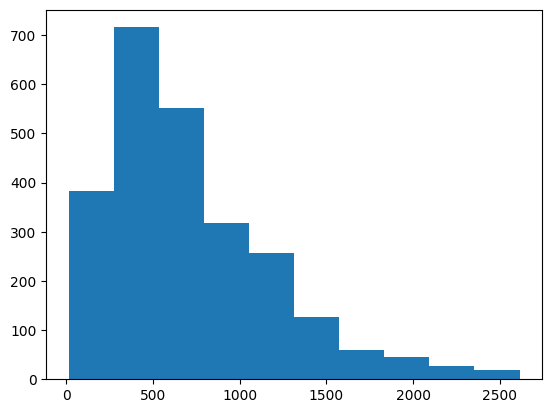

In [ ]:
# Create a histogram of all the predictions
#matplotlib.pyplot.hist() #pass the prediction values
matplotlib.pyplot.hist(y_pred,)

print('Histogram generation successful!')

#Question 4: Model Prediction Improvements

**Analyze the model predictions. Does the output distribution match the one you made earlier in the case study? What other features/strategies could we use to make our model even better, if we had more time?**










**ANSWER 4:**

*The output histogram appears to match the original one quite closely.  However there is room for improvement of the model.  Some possible improvements are:*

**Better feature selectivty:** *Based on the outputs achieved we can be more selective with the features used in the training dataset and eliminate those features that do not have a singnificant impact on the model.*

**Additional Features:**  *We can add features to our training set to consider other temporal features such as ``time_of_day`` (eg. Morning, Afternoon, Evening, Night, etc..) and ``season`` (eg. Spring, Summer, Autumn, etc...) to capture any  seasonaliy trends in the dataset.
Possibly we can also retrieve ``weather`` data for a given ``neighbourhood`` at a given ``timedate`` from a third party dataset to see to what extent weather conditions impact ``trip_duration``.*

*It might also be intersting to generate a set of features related to the ``distance`` of the ``pickup_location`` and ``dropoff_location`` to popular landmarks and points of interest.  This could expose significant correlations between `trip_duration` and how close/far away from a point-of-interest passengers are picked up and dropped off.*


---


#Feature Importance

In [ ]:
def feature_importances(model, feature_names, n=10):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i + 1, f[0], f[1]))

In [ ]:
feature_importances(model, feature_matrix.columns, n=25)

1: Feature: trip_distance, 0.867
2: Feature: dropoff_neighborhoods.longitude, 0.029
3: Feature: HOUR(pickup_datetime), 0.027
4: Feature: dropoff_neighborhoods.latitude, 0.022
5: Feature: HOUR(dropoff_datetime), 0.013
6: Feature: pickup_neighborhoods.longitude, 0.004
7: Feature: pickup_neighborhoods.COUNT(trips), 0.004
8: Feature: MINUTE(dropoff_datetime), 0.003
9: Feature: dropoff_neighborhoods.COUNT(trips), 0.003
10: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.002
11: Feature: pickup_neighborhoods.latitude, 0.002
12: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
13: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.002
14: Feature: pickup_neighborhoods.MEAN(trips.payment_type), 0.002
15: Feature: MINUTE(pickup_datetime), 0.002
16: Feature: pickup_neighborhoods.MEAN(trips.passenger_count), 0.002
17: Feature: dropoff_neighborhoods.MAX(trips.trip_distance), 0.001
18: Feature: dropoff_neighborhoods.SUM(trips.vendor_id), 0.001
19: Feature: dropoff_

Question 5: Feature Importance

**Analyze the feature importance values you just computed above. Do they make sense? Are there any values you are surprised by? Give some brief explanations as to why these features are relevant in computing the `trip_duration` target variable.**

**ANSWER 5:**

*`trip_distance` is the most significant feature - which is to be expected since the longer the distance of the trip, the longer one would expect the trip duration to be.*

*The next most significant features are `dropoff_neighbourhoods.longitude`, `HOUR(pickup_datetime)`,`dropoff_neighbourhoods.latitude`, and `HOUR(dropoff_datetime)`.*  
*The pickup and dropoff hours will affect the `trip_duration` as the roads will have more or less traffic on them depending on the time of day.  The latitude and longitude of the dropoff neighbourhoods will affect the `trip_duration` since some areas may be busier, or harder to get to in general, and will result in longer trip times.*

*What is  surprising (and somewhat counter-intuitive) to me is that while the location (latitude and longitude) of the **dropoff** neighbourhood is having a significant effect on `trip_duration`, the effect of the location of the **pickup** neighbourhood is a lot less significant. I would have expected these features to be almost equally as important.  This is most likely because Taxi drivers will normally patrol a specific area (or park in a given taxi stand) and therefore most of their trips will have the same `pickup_neighborhood` and therefore the `dropoff_neighbourhood` will have a much greater impact on the `trip_duration`.*

*It is worth noting that of the top 5 most significant features, three were included in the original dataset and two where from the first set of transform primitives generated.*

*The second set of generated primitives added an additional 50 features, of which **only three** are amongst the top 10 most significant features and are of a relatively lower significance.  This helps explain why the R^2 value of the second training model was lower, since the spuriously added features created noise in the model lowering its accuracy.*

---



